In [15]:
import sys 

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl
sys.path.append('../src/construct/')
import util
from shapely.geometry import box


idx = pd.IndexSlice

In [23]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})
mpl.rcParams['text.latex.preamble'] = [
    #r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
    #r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
    r'\usepackage{helvet}',    # set the normal font here
    r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
    r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

In [4]:
units = gpd.read_file('../land-eligibility/build/eurospores/units.geojson').set_index('id')
demand = util.read_tdf('../build/eurospores/annual-demand.csv')
electricity_demand = pd.read_csv('../build/model/eurospores/electricity-demand.csv', index_col=0, parse_dates=True)
space_heat_demand = pd.read_csv('../build/model/eurospores/space-heat-demand.csv', index_col=0, parse_dates=True)
water_heat_demand = pd.read_csv('../build/model/eurospores/water-heat-demand.csv', index_col=0, parse_dates=True)
cooking_demand = pd.read_csv('../build/model/eurospores/cooking-demand.csv', index_col=0, parse_dates=True)

mean_annual_demand = demand.drop(demand.filter(regex=r'bau', axis=0).index).mean(level=['dataset', 'cat_name', 'id', 'end_use'])#.unstack(['dataset', 'end_use', 'cat_name'])

annual_electricity_demand = -1 * electricity_demand.sum()
building_electricity = annual_electricity_demand - mean_annual_demand.xs('electricity', level='end_use').sum(level='id')

In [285]:
figure_data_dict = {
    ('Building demand', 'Space Heat', 'TWh'): mean_annual_demand[ idx[:, :, :, 'space_heat']].sum(level='id') / 10,
    ('Building demand', 'Hot water', 'TWh'): mean_annual_demand[idx[:, :, :, 'water_heat']].sum(level='id') / 10,
    ('Building demand', 'Cooking heat', 'TWh'): mean_annual_demand[idx[:, :, :, 'cooking']].sum(level='id') / 10,
    ('Building demand', 'Electricity', 'TWh'): building_electricity / 10,
    ('Industry demand', 'Energy feedstock', 'TWh LHV'): mean_annual_demand.loc[idx[:, :, :, ['hydrogen', 'methanol']]].sum(level='id') / 10,
    ('Industry demand', r'CO$_2$ feedstock', 'kt'): mean_annual_demand[idx[:, :, :, 'co2']].sum(level='id'),
    ('Industry demand', 'High enthalpy heat', 'TWh methane'): mean_annual_demand[idx[:, :, :, 'natural_gas']].sum(level='id') / 10,
    ('Industry demand', 'Electricity', 'TWh'): mean_annual_demand.loc[idx['industry_demand', 'industry', :, 'electricity']].sum(level='id') / 10,
    ('Transport demand', r'Passenger car mileage', 'x10$^{10}$ km'): mean_annual_demand[idx[:, :, :, 'passenger_car']].sum(level='id'),
    ('Transport demand', r'Other vehicles mileage', 'x10$^{10}$ km'): mean_annual_demand.loc[idx[:, :, :, ['motorcycle', 'bus', 'ldv', 'hdv']]].sum(level='id'),
    ('Transport demand', 'Air/shipping fuel', 'TWh LHV'): mean_annual_demand.loc[idx[:, ['air', 'shipping'], :, :]].sum(level='id') / 10,
    ('Transport demand', 'Rail electricity', 'TWh'): mean_annual_demand[idx[:, 'rail', :, 'electricity']].sum(level='id') / 10
}
figure_data_df = pd.concat(figure_data_dict.values(), axis=1, keys=figure_data_dict.keys())

In [42]:
mean_annual_demand.xs('electricity', level='end_use').unstack('cat_name')

cat_name                   industry       rail
dataset          id                           
industry_demand  ALB_1    23.776687   0.215044
                 AUT_1    69.269819   0.879520
                 AUT_2   527.964323   5.821275
                 AUT_3   143.645221   1.666376
                 BEL_1  1027.744485   3.917940
...                             ...        ...
transport_demand SVN_1          NaN   1.304131
                 SWE_1          NaN   0.472162
                 SWE_2          NaN   1.745743
                 SWE_3          NaN  12.882558
                 SWE_4          NaN   3.772284

[196 rows x 2 columns]

In [31]:
demand.drop(demand.filter(regex=r'bau', axis=0).index).loc[idx[:, :, 2016, :, :, ['heat', 'cooking']]].sum(level='id').max()

65.89837122799189

In [17]:
energy_scaling_factor = 10
model_year = 2016

In [62]:
mean_annual_demand.loc[idx[:, :, :, ['hydrogen', 'methanol', 'methane', 'kerosene', 'diesel']]].unstack('end_use').sum()

end_use
kerosene     6268.558035
diesel       6670.463843
methane      5734.622316
methanol    11363.525072
dtype: float64

In [56]:
figure_data_dict = {
    ('Building Heat', 'TWh'): mean_annual_demand.loc[idx[:, :, :, ['space_heat', 'water_heat', 'cooking']]].sum(level='id') / energy_scaling_factor,
    #('Building demand', 'Hot water', 'TWh'): mean_annual_demand[idx[:, :, :, 'water_heat']].sum(level='id') / energy_scaling_factor,
    #('Building demand', 'Cooking heat', 'TWh'): mean_annual_demand[idx[:, :, :, 'cooking']].sum(level='id') / energy_scaling_factor,
    ('Electricity', 'TWh'): annual_electricity_demand / energy_scaling_factor,
    ('Synthetic fuel', 'TWh LHV'): mean_annual_demand.loc[idx[:, :, :, ['hydrogen', 'methanol', 'methane', 'kerosene', 'diesel']]].sum(level='id') / energy_scaling_factor,
    #('Industry demand', 'CO$_2$ feedstock', 'kt'): mean_annual_demand[idx[:, :, :, 'co2']].sum(level='id'),
    #('Industry demand', 'High enthalpy heat', 'TWh methane'): mean_annual_demand[idx[:, :, :, 'methane']].sum(level='id') / energy_scaling_factor,
    #('Transport demand', 'Electricity', 'TWh'): mean_annual_demand.loc[idx['industry_demand', 'industry', :, 'electricity']].sum(level='id') / energy_scaling_factor,
    ('Road vehicle mileage', 'x10$^{10}$ km'): mean_annual_demand.loc[idx[:, :, :, ['motorcycle', 'bus', 'ldv', 'hdv', 'passenger_car']]].sum(level='id'),
    #('Transport demand', 'Other vehicles mileage', 'x10$^{10}$ km'): mean_annual_demand.loc[idx[:, :, :, ['motorcycle', 'bus', 'ldv', 'hdv']]].sum(level='id'),
    #('Transport demand', 'Air/shipping fuel', 'TWh LHV'): mean_annual_demand.loc[idx[:, ['air', 'shipping'], :, :]].sum(level='id') / energy_scaling_factor,
   #('Transport demand', 'Rail electricity', 'TWh'): mean_annual_demand[idx[:, 'rail', :, 'electricity']].sum(level='id') / energy_scaling_factor
}
figure_data_df = pd.concat(figure_data_dict.values(), axis=1, keys=figure_data_dict.keys())

In [13]:
timeseries = pd.concat(
    [electricity_demand.sum(axis=1),
     space_heat_demand.sum(axis=1) + water_heat_demand.sum(axis=1) + cooking_demand.sum(axis=1)],
    keys=['Electricity', 'Building heat'],
    axis=1
).div(-1 * 10)
timeseries['Fuel'] = (
    figure_data_df
    .loc[:, idx[:, ['Synthetic fuel'], :]]
    .sum().sum()
    / len(timeseries)
)

In [59]:
plot_gdf = units[['country_code', 'geometry']].merge(figure_data_df, right_index=True, left_index=True).to_crs('epsg:3035')

national_gdf_geom = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2016_3857_LEVL_0.geojson').set_index('CNTR_CODE').to_crs(plot_gdf.crs)
national_gdf = gpd.GeoDataFrame(gpd.clip(national_gdf_geom.geometry.explode(), box(*plot_gdf.total_bounds)).reset_index('CNTR_CODE')).dissolve('CNTR_CODE')
national_gdf.index = national_gdf.index.map(util.get_alpha3)
national_gdf = national_gdf.merge(plot_gdf.groupby('country_code').sum(), right_index=True, left_index=True)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [68]:
current_electricity_demand = pd.read_csv('../euro-calliope/build/model/eurospores/electricity-demand.csv', index_col=0, parse_dates=True)

In [69]:
timeseries = pd.concat(
    [electricity_demand.sum(axis=1), 
     space_heat_demand.sum(axis=1) + water_heat_demand.sum(axis=1) + cooking_demand.sum(axis=1)],
    keys=['Electricity', 'Building heat'],
    axis=1
).div(-1 * 10)
timeseries['Fuel'] = figure_data_df['Synthetic fuel'].sum().sum() / len(timeseries)
current_timeseries = current_electricity_demand.sum(axis=1).div(-1 * 10)

In [106]:
cmaps = {
    'Air/shipping fuel': 'GnBu', #'OrRd', 
    'CO$_2$ feedstock': 'GnBu', #'BuPu', 
    'Cooking heat': 'Oranges', #'OrRd', 
    'Electricity': 'Blues',
    'Energy feedstock': 'GnBu', #'BuPu', 
    'High enthalpy heat': 'YlOrRd', #'OrRd', 
    'Hot water': 'Oranges', #'OrRd',
    'Other vehicles mileage': 'BuPu', 
    'Road vehicle mileage': 'BuPu', 
    'Passenger car mileage': 'BuPu', 
    'Rail electricity': 'Blues',
    'Space Heat': 'Oranges', #'OrRd'
    'Heat': 'Oranges', #'OrRd'
    'Building Heat': 'Oranges', #'OrRd'
    'Synthetic fuel': 'GnBu', #'BuPu', 
}
timeseries_colors = {
    'Fuel': '#a1dab4',
    #'Industry feedstock': '#abd9e9', # 'lightslategray', 
    'Building heat': '#fdae61', # 'steelblue', 
    'Electricity': '#2c7bb6', # 'forestgreen', 
}

In [88]:
handles[0]

In [93]:
timeseries

,Electricity,Building heat,Fuel
2016-01-01 00:00:00,0.423480,0.293791,0.341953
2016-01-01 01:00:00,0.409719,0.301111,0.341953
2016-01-01 02:00:00,0.392299,0.324743,0.341953
2016-01-01 03:00:00,0.372225,0.386335,0.341953
2016-01-01 04:00:00,0.347939,0.506703,0.341953
...,...,...,...
2016-12-31 19:00:00,0.420422,0.550979,0.341953
2016-12-31 20:00:00,0.430369,0.492535,0.341953
2016-12-31 21:00:00,0.446400,0.415105,0.341953
2016-12-31 22:00:00,0.451382,0.352814,0.341953


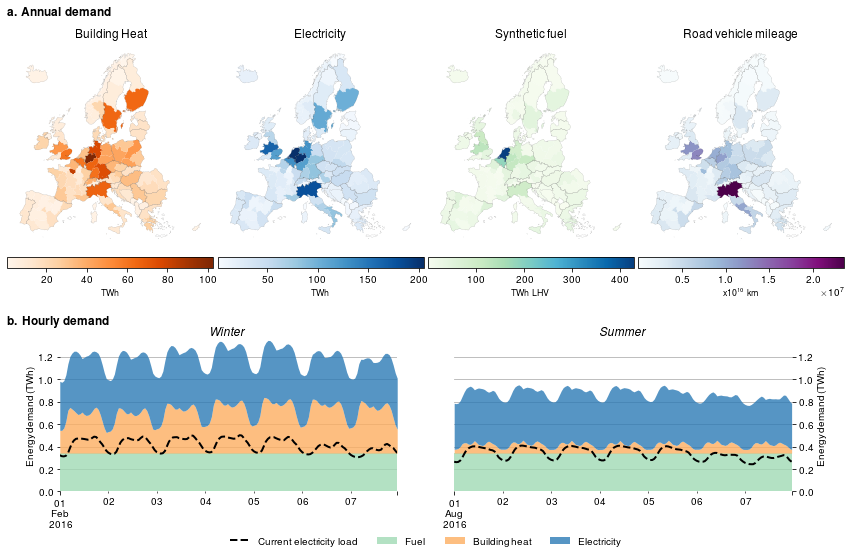

In [107]:
ncols = 32
fig = plt.figure(figsize=(15, 10))
g = plt.GridSpec(
    nrows=5, ncols=ncols, figure=fig,
    height_ratios=[1, 10, 1, 6, 2], hspace=0.1
)
axes = {}
axes['annual_title'] = plt.subplot(g[0, :], frameon=False)
axes['annual_title'].axis('off')
axes['annual_title'].set_title('\\textbf{a. Annual demand}', fontweight='bold', loc='left', y=0.5)
r = 1
c = 0    
for col in figure_data_df.columns:
    axes[col] = plt.subplot(g[r, int(c * (ncols / 4)):int(c * (ncols / 4) + (ncols / 4))], frameon=False)
    axes[col].axis('off')
    c += 1
    
    plot_gdf.plot(
        col, ax=axes[col], cmap=cmaps[col[0]], legend=True,
        legend_kwds={'label': f'\\small{{{col[1]}}}', 'orientation': 'horizontal', 'pad': 0.03}
    )
    national_gdf.plot(fc='None', ec='black', lw=0.1, ax=axes[col], legend=False, linestyle='dashed')
    axes[col].set_title(col[0])
    
timeseries_axes = {
    'Title': plt.subplot(g[-3, :], frameon=False),
    'Winter': plt.subplot(g[-2, 2:int(ncols / 2) - 1], frameon=False),
    'Summer': plt.subplot(g[-2, int(ncols / 2) + 1:ncols - 2], frameon=False),
    'Legend': plt.subplot(g[-1, :], frameon=False),
}
timeseries_dates = {
    'Winter': slice(f'{model_year}-02-01', f'{model_year}-02-07'),
    'Summer': slice(f'{model_year}-08-01', f'{model_year}-08-07')
}
timeseries_axes['Title'].axis('off')
timeseries_axes['Legend'].axis('off')
timeseries_axes['Title'].set_title('\\textbf{b. Hourly demand}', fontweight='bold', loc='left', y=0)
for i in ['Winter', 'Summer']:
    timeseries_axes[i].set_title(f'\\textit{{{i}}}', loc='center')
    timeseries_axes[i].set_ylim(0, max(timeseries.loc[v].sum(axis=1).max() for v in timeseries_dates.values()))
    timeseries.loc[timeseries_dates[i], timeseries_colors.keys()].plot.area(ax=timeseries_axes[i], legend=False, alpha=0.8, lw=0, color=timeseries_colors.values())
    current_timeseries.rename('Current electricity load').rename_axis(None).loc[timeseries_dates[i]].plot(ax=timeseries_axes[i], lw=2, c='black', linestyle='--')
    timeseries_axes[i].yaxis.grid(True, zorder=-1)
    timeseries_axes[i].set_axisbelow(True)
    timeseries_axes[i].set_ylabel('Energy demand (TWh)')
timeseries_axes['Summer'].yaxis.set_label_position("right")
timeseries_axes['Summer'].yaxis.tick_right()

handles, labels = timeseries_axes['Winter'].get_legend_handles_labels()
legend = timeseries_axes['Legend'].legend(
    labels=labels, handles=handles, loc='upper center', bbox_to_anchor=[0.5, 0.5], ncol=5, frameon=False
)

TypeError: can only concatenate tuple (not "str") to tuple

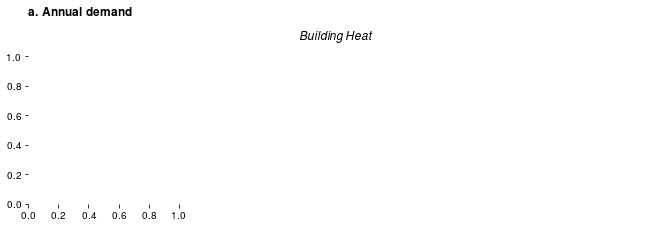

In [70]:

ncols = 32
fig = plt.figure(figsize=(11, 15))
g = plt.GridSpec(nrows=10, ncols=ncols, figure=fig, height_ratios=[1, 1, 10, 2.5, 10, 2.5, 10, 3, 6, 4], hspace=0.12)
axes = {}
axes['annual_title'] = plt.subplot(g[0, :], frameon=False)
axes['annual_title'].axis('off')
axes['annual_title'].set_title('\\textbf{a. Annual demand}', fontweight='bold', loc='left', y=0.2)
r = 1
for row in figure_data_df.columns.levels[0]:
    c = 0
    axes[row] = plt.subplot(g[r, :], frameon=False)
    axes[row].axis('off')
    axes[row].set_title(f'\\textit{{{row}}}', loc='center', y=0.1)
    r += 1
    for col in figure_data_df.xs(row, axis=1).columns:
        axes[(row, ) + col] = plt.subplot(g[r, int(c*(ncols/4)):int(c*(ncols/4)+(ncols/4))], frameon=False)
        axes[(row, ) + col].axis('off')
        axes[(row, ) + col].set_title(col[0])
        c += 1
    r += 1
for col in figure_data_df.columns:
    if col[1] == 'Air/shipping fuel':
        national_gdf.plot(
            col, ax=axes[col], cmap=cmaps[col[1]], legend=True, 
            legend_kwds={'label': f'\\small{{{col[2]}}}', 'orientation': 'horizontal', 'pad': 0.03}
        )
    else:
        plot_gdf.plot(
            col, ax=axes[col], cmap=cmaps[col[1]], legend=True, 
            legend_kwds={'label': f'\\small{{{col[2]}}}', 'orientation': 'horizontal', 'pad': 0.03}
        )
    national_gdf.plot(fc='None', ec='black', lw=0.1, ax=axes[col], legend=False, linestyle='dashed')
    
timeseries_axes = {
    'Title': plt.subplot(g[-3, :], frameon=False),
    'Winter': plt.subplot(g[-2, 2:int(ncols/2)-1], frameon=False),
    'Summer': plt.subplot(g[-2, int(ncols/2)+1:ncols-2], frameon=False),
    'Legend': plt.subplot(g[-1, :], frameon=False),
}
timeseries_dates = {
    'Winter': slice(f'{model_year}-02-01', f'{model_year}-02-07'),
    'Summer': slice(f'{model_year}-08-01', f'{model_year}-08-07')
}
timeseries_axes['Title'].axis('off')
timeseries_axes['Legend'].axis('off')
timeseries_axes['Title'].set_title('\\textbf{b. Hourly demand}', fontweight='bold', loc='left', y=0)
for i in ['Winter', 'Summer']:
    timeseries_axes[i].set_title(f'\\textit{{{i}}}', loc='center')
    timeseries_axes[i].set_ylim(0, max(timeseries.loc[v].sum(axis=1).max() for v in timeseries_dates.values()))
    timeseries.loc[timeseries_dates[i], timeseries_colors.keys()].plot.area(ax=timeseries_axes[i], legend=False, alpha=0.8, lw=0, color=timeseries_colors.values())
    current_timeseries.loc[timeseries_dates[i]].plot.scatter(ax=timeseries_axes[i], legend=False, alpha=0.8, lw=1, color='black')
    timeseries_axes[i].yaxis.grid(True, zorder=-1)
    timeseries_axes[i].set_axisbelow(True)
    timeseries_axes[i].set_ylabel('Energy demand (TWh)')

handles, labels = timeseries_axes['Winter'].get_legend_handles_labels()
timeseries_axes['Summer'].yaxis.set_label_position("right")
timeseries_axes['Summer'].yaxis.tick_right()

legend = timeseries_axes['Legend'].legend(
    labels=labels, handles=handles, loc='upper center', bbox_to_anchor=[0.5, 0.5], ncol=5, frameon=False
)

In [363]:
fig.savefig('test.pdf', pad_inches=0, bbox_inches='tight')